Setup: Libraries

In [747]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import ttest_ind
from scipy.stats import f_oneway
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder

pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)


Get Data

In [748]:
data = pd.read_excel('dataset/Package Pricing at Mission Hospital - Data Supplement.xlsx', sheet_name='MH-Raw Data')

Data Cleaning

In [749]:
data['MARITAL STATUS'] = data['MARITAL STATUS'].str.capitalize()
data['PAST MEDICAL HISTORY CODE'] = data['PAST MEDICAL HISTORY CODE'].str.capitalize()
data['MODE OF ARRIVAL'] = data['MODE OF ARRIVAL'].str.capitalize()
data['STATE AT THE TIME OF ARRIVAL'] = data['STATE AT THE TIME OF ARRIVAL'].str.capitalize()
data['TYPE OF ADMSN'] = data['TYPE OF ADMSN'].str.capitalize()

data['AGE'] = data['AGE'].astype('int64')


In [750]:
# Finding Null Values
cols_check = [col for col in data.columns if not((col == 'PAST MEDICAL HISTORY CODE') | (col == 'KEY COMPLAINTS -CODE'))]
#data[data[cols_check].isnull().any(axis=1)]

Data Prep

In [751]:
# Age group categories
data['AGE_GROUP'] = '50+'

age_conditions = [
    (data['AGE'] <= 10),
    ((data['AGE'] > 10) & (data['AGE'] <= 25)),
    ((data['AGE'] > 25) & (data['AGE'] <= 50))
]

age_groups = ['<10', '11-25', '26-50']

data['AGE_GROUP'] = np.select(age_conditions, age_groups, default='50+')

# Hemoglobin Categories
data['HB_LEVEL'] = np.where(
    (data['HB'].isna()) |
    ((data['GENDER'] == 'F') & (data['HB'] >= 12.5) & (data['HB'] <= 15.5)) |
    ((data['GENDER'] == 'M') & (data['HB'] >= 13) & (data['HB'] <= 17.5)), 
    'NORMAL', 'ABNORMAL')

# BP Categories
bp_conditions = [
    (data['BP -HIGH'] < 120) & (data['BP-LOW'] < 80),
    (data['BP -HIGH'] > 119) & (data['BP -HIGH'] < 130) & (data['BP-LOW'] < 80),
    ((data['BP -HIGH'] > 129) & (data['BP -HIGH'] < 140)) | ((data['BP-LOW'] > 79) & (data['BP-LOW'] < 90)),
    (data['BP -HIGH'] >= 140) | (data['BP-LOW'] >= 90),
    (data['BP -HIGH'] > 180) | (data['BP-LOW'] > 120)
]

bp_groups = ['NORMAL','ELEVATED', 'HYPERTENSION STAGE 1', 'HYPERTENSION STAGE 2', 'HYPERTENSIVE CRISIS']

data['BP_RANGE'] = np.select(bp_conditions, bp_groups, default='NORMAL')

# Urea Categories
data['UREA_CAT'] = np.where(
    (data['UREA'].isna()) |
    ((data['GENDER'] == 'F') & (data['UREA'] >= 6) & (data['UREA'] < 21)) |
    ((data['GENDER'] == 'M') & (data['UREA'] >= 7) & (data['UREA'] <= 20)), 
    'NORMAL', 'ABNORMAL'
)


# BMI Categories
# Calculate BMI
data['BMI_VALUE'] = data['BODY WEIGHT'] / (data['BODY HEIGHT']/100) ** 2

bmi_conditions = [
    (data['BMI_VALUE'] <= 18.5),
    (data['BMI_VALUE'] > 18.5) & (data['BMI_VALUE'] < 25),
    (data['BMI_VALUE'] >= 25) & (data['BMI_VALUE'] < 30),
    (data['BMI_VALUE'] >= 30)
]

bmi_groups = ['UNDERWEIGHT', 'NORMAL', 'OVERWEIGHT', 'OBESE']

data['BMI_CAT'] = np.select(bmi_conditions, bmi_groups, default='OBESE')

# Creatinine Categories
data['CREATININE_CAT'] = np.where(
    (data['CREATININE'].isna()) |
    ((data['AGE'] <= 3) & (data['CREATININE'] >= 0.3) & (data['CREATININE'] <= 0.7)) |
    ((data['AGE'] > 3) & (data['AGE'] <= 18) & (data['CREATININE'] >= 0.5) & (data['CREATININE'] <= 1.0)) |
    ((data['AGE'] > 18) & (data['GENDER'] == 'F') & (data['CREATININE'] >= 0.6) & (data['CREATININE'] <= 1.1)) |
    ((data['AGE'] > 18) & (data['GENDER'] == 'M') & (data['CREATININE'] >= 0.9) & (data['CREATININE'] <= 1.3)),
    'NORMAL',
    'ABNORMAL'
)



Exploring Data - Univariate Analysis

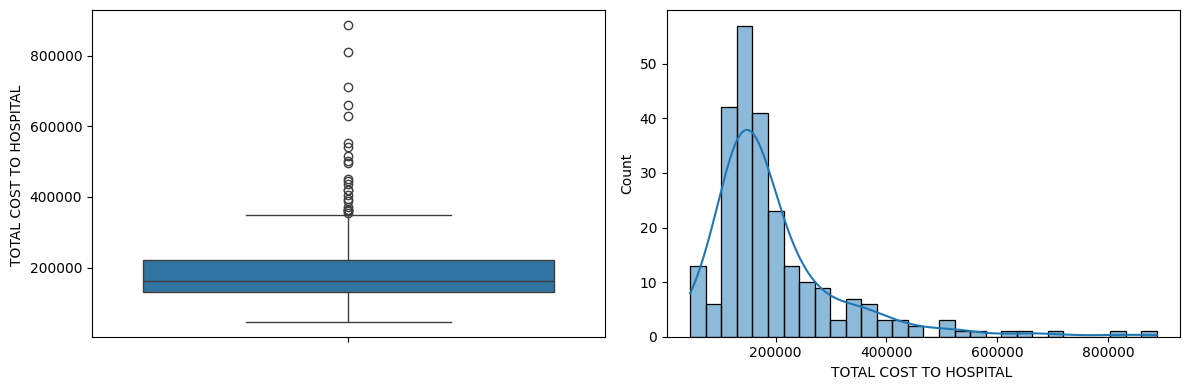

In [752]:
# Total cost to hospital
fig, axes = plt.subplots(1,2,figsize=(12,4)) 
sns.boxplot(data['TOTAL COST TO HOSPITAL '], ax=axes[0])
sns.histplot(data['TOTAL COST TO HOSPITAL '], kde=True, ax=axes[1])
plt.tight_layout()
plt.show()


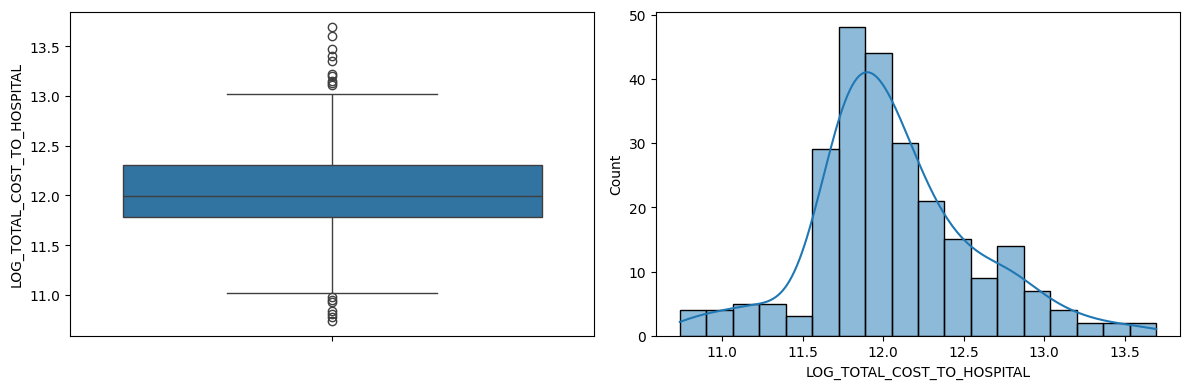

In [753]:
# Data is right-skewed so using natural log to normalize
fig, axes = plt.subplots(1,2,figsize=(12,4)) 
data['LOG_TOTAL_COST_TO_HOSPITAL'] = np.log(data['TOTAL COST TO HOSPITAL '])
sns.boxplot(data['LOG_TOTAL_COST_TO_HOSPITAL'], ax=axes[0])
sns.histplot(data['LOG_TOTAL_COST_TO_HOSPITAL'], kde=True, ax=axes[1])
plt.tight_layout()
plt.show()

In [754]:
# Function to return value count and frequency, as well as mean cost
def value_count_freq(col):
    val_count = col.value_counts()
    freq = col.value_counts(normalize=True) * 100
    mean_cost = data['LOG_TOTAL_COST_TO_HOSPITAL'].groupby(col).mean()
    val_concat = pd.concat([val_count, freq, mean_cost], axis=1)
    val_concat.columns = ['Count', 'Frequency (%)', 'Mean']
    return val_concat

### Statistical Tests & Variable Reduction

T Tests

In [755]:
# T Test for Gender
display(value_count_freq(data['GENDER']))
male_cost = data[data['GENDER'] == 'M']['LOG_TOTAL_COST_TO_HOSPITAL']
female_cost = data[data['GENDER'] == 'F']['LOG_TOTAL_COST_TO_HOSPITAL']
t_stat, p_value = ttest_ind(male_cost, female_cost, equal_var=False)
print("GENDER")
print(f"T-statistic: {t_stat}")
print(f"P-value: {p_value}")

# T Test for Marital Status
display(value_count_freq(data['MARITAL STATUS']))
married_cost = data[data['MARITAL STATUS'] == 'Married']['LOG_TOTAL_COST_TO_HOSPITAL']
unmarried_cost = data[data['MARITAL STATUS'] == 'Unmarried']['LOG_TOTAL_COST_TO_HOSPITAL']
t_stat, p_value = ttest_ind(married_cost, unmarried_cost, equal_var=False)
print("MARITAL STATUS")
print(f"T-statistic: {t_stat}")
print(f"P-value: {p_value}")

# T Test for Urea Category
display(value_count_freq(data['UREA_CAT']))
normal_cost = data[data['UREA_CAT'] == 'NORMAL']['LOG_TOTAL_COST_TO_HOSPITAL']
abnormal_cost = data[data['UREA_CAT'] == 'ABNORMAL']['LOG_TOTAL_COST_TO_HOSPITAL']
t_stat, p_value = ttest_ind(normal_cost, abnormal_cost, equal_var=False)
print("UREA LEVEL")
print(f"T-statistic: {t_stat}")
print(f"P-value: {p_value}")

# T Test for HB Level
display(value_count_freq(data['HB_LEVEL']))
normal_cost = data[data['HB_LEVEL'] == 'NORMAL']['LOG_TOTAL_COST_TO_HOSPITAL']
abnormal_cost = data[data['HB_LEVEL'] == 'ABNORMAL']['LOG_TOTAL_COST_TO_HOSPITAL']
t_stat, p_value = ttest_ind(normal_cost, abnormal_cost, equal_var=False)
print("HB LEVEL")
print(f"T-statistic: {t_stat}")
print(f"P-value: {p_value}")

# T Test for Creatinine Level
display(value_count_freq(data['CREATININE_CAT']))
normal_cost = data[data['CREATININE_CAT'] == 'NORMAL']['LOG_TOTAL_COST_TO_HOSPITAL']
abnormal_cost = data[data['CREATININE_CAT'] == 'ABNORMAL']['LOG_TOTAL_COST_TO_HOSPITAL']
t_stat, p_value = ttest_ind(normal_cost, abnormal_cost, equal_var=False)
print("CREATININE CATEGORY")
print(f"T-statistic: {t_stat}")
print(f"P-value: {p_value}")

,Count,Frequency (%),Mean
GENDER,,,
M,166,66.935484,12.125180
F,82,33.064516,11.934355


GENDER
T-statistic: 2.8529046932288042
P-value: 0.004891094559017045


,Count,Frequency (%),Mean
MARITAL STATUS,,,
Unmarried,140,56.451613,11.884857
Married,108,43.548387,12.291824


MARITAL STATUS
T-statistic: 6.660985844709109
P-value: 2.521738870633243e-10


,Count,Frequency (%),Mean
UREA_CAT,,,
ABNORMAL,137,55.241935,12.108387
NORMAL,111,44.758065,12.004936


UREA LEVEL
T-statistic: -1.6420852581114334
P-value: 0.10185014457722881


,Count,Frequency (%),Mean
HB_LEVEL,,,
ABNORMAL,162,65.322581,12.040969
NORMAL,86,34.677419,12.101859


HB LEVEL
T-statistic: 0.8882296929603749
P-value: 0.37570485285608823


,Count,Frequency (%),Mean
CREATININE_CAT,,,
NORMAL,151,60.887097,12.058893
ABNORMAL,97,39.112903,12.067053


CREATININE CATEGORY
T-statistic: -0.1183298722370216
P-value: 0.9059427107705136


In [756]:
# Function to run T Tests on different Key Complaints
def complaint_ttests(data, complaint_col, cost_col):
    categories = data[complaint_col].dropna().unique()
    results = []

    for cat in categories:
        group_cost = data[data[complaint_col] == cat][cost_col]
        rest_cost = data[data[complaint_col] != cat][cost_col]

        # Run T-test
        t_stat, p_value = ttest_ind(group_cost, rest_cost, equal_var=False)

        # Store results
        results.append({
            'Complaint Category': cat,
            'Count (Category)': len(group_cost),
            'Mean Cost (Category)': np.round(group_cost.mean(), 2),
            'Mean Cost (Rest)': np.round(rest_cost.mean(), 2),
            'T-statistic': np.round(t_stat, 4),
            'P-value': np.round(p_value, 4)
        })

    # Convert to DataFrame
    return pd.DataFrame(results).sort_values('P-value')

In [757]:
results_df = complaint_ttests(data, 'KEY COMPLAINTS -CODE', 'LOG_TOTAL_COST_TO_HOSPITAL')
display(results_df)

results_df = complaint_ttests(data, 'PAST MEDICAL HISTORY CODE', 'LOG_TOTAL_COST_TO_HOSPITAL')
display(results_df)


,Complaint Category,Count (Category),Mean Cost (Category),Mean Cost (Rest),T-statistic,P-value
3,RHD,26,12.38,12.02,4.6389,0.0000
1,CAD-DVD,27,12.51,12.01,4.6139,0.0001
9,OS-ASD,15,11.85,12.08,-4.4143,0.0001
2,CAD-TVD,24,12.42,12.02,3.9513,0.0005
8,ACHD,19,11.66,12.10,-3.6967,0.0013
10,PM-VSD,6,11.88,12.07,-3.2339,0.0085
5,other- respiratory,15,11.83,12.08,-1.9315,0.0712
0,other- heart,55,12.00,12.08,-0.9601,0.3398
7,other-tertalogy,18,12.02,12.07,-0.9379,0.3525
6,other-nervous,3,11.89,12.06,-0.5705,0.6248


,Complaint Category,Count (Category),Mean Cost (Category),Mean Cost (Rest),T-statistic,P-value
0,Diabetes2,9,12.79,12.03,5.2178,0.0006
1,Hypertension1,23,12.37,12.03,3.4441,0.0018
5,Other,15,11.75,12.08,-2.8256,0.0119
3,Hypertension2,13,11.89,12.07,-2.2494,0.0379
4,Diabetes1,10,12.31,12.05,1.4337,0.1833
2,Hypertension3,5,12.26,12.06,0.8214,0.4561


ANOVA

In [758]:
# Anova helper function
def run_anova(data, group_col, value_col):
    categories = data[group_col].dropna().unique()
    groups = [data[data[group_col] == cat][value_col] for cat in categories]

    f_stat, p_value = f_oneway(*groups)

    print(f"ANOVA Results ---> {group_col}:")
    print(f"F-statistic: {f_stat:.4f}")
    print(f"P-value: {p_value:.4e}")
    print()

In [759]:
run_anova(data, 'KEY COMPLAINTS -CODE', 'LOG_TOTAL_COST_TO_HOSPITAL')
run_anova(data, 'AGE_GROUP', 'LOG_TOTAL_COST_TO_HOSPITAL')
run_anova(data, 'BP_RANGE', 'LOG_TOTAL_COST_TO_HOSPITAL')
run_anova(data, 'BMI_CAT', 'LOG_TOTAL_COST_TO_HOSPITAL')

ANOVA Results ---> KEY COMPLAINTS -CODE:
F-statistic: 7.1001
P-value: 1.0247e-10

ANOVA Results ---> AGE_GROUP:
F-statistic: 18.9332
P-value: 4.5096e-11

ANOVA Results ---> BP_RANGE:
F-statistic: 4.1825
P-value: 6.5419e-03

ANOVA Results ---> BMI_CAT:
F-statistic: 11.6216
P-value: 3.8094e-07



Insig:
- other resp, other heart, other tert, other nerv, cad svd, cad vsd, other gen
- diabetes1, hypertension3
- HB, Urea, Creatinine

# Data Prep Pipeline